In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 11.9 MB/s 
     |████████████████████████████████| 596 kB 59.8 MB/s 
     |████████████████████████████████| 101 kB 6.3 MB/s 
     |████████████████████████████████| 6.6 MB 53.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
# for uncompressing the .zip file

"""

import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/data/Akhbarona.zip","r") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/data/akhbarna/")

"""

'\n\nimport zipfile\nwith zipfile.ZipFile("/content/drive/MyDrive/data/Akhbarona.zip","r") as zip_ref:\n    zip_ref.extractall("/content/drive/MyDrive/data/akhbarna/")\n\n'

In [4]:
import string
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import re
import gensim
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import glob
import tensorflow as tf
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.layers as lay
import matplotlib.pyplot as plt

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Reading data

In [5]:
number_of_samples=200
dataset_path="/content/drive/MyDrive/data/akhbarna"

classes={}
i=0
for category in glob.glob(dataset_path+"/*"):
  classes[ category.split("/")[-1] ]=i
  i+=1

data=pd.DataFrame(columns=["text","class"])

for category in glob.glob(dataset_path+"/*"):
  if os.path.isfile(category):
    continue
  files=glob.glob(category+"/*.txt")[:number_of_samples]
  for sample_file in files:
    with open(sample_file) as f:
      text = f.read()
      clas=classes[ category.split("/")[-1] ]
      data = pd.concat([ data , pd.DataFrame([ [text,clas] ], columns=data.columns) ], ignore_index=True)
  
  print(category.split("/")[-1]+" samples loaded !\n")



Culture samples loaded !

Finance samples loaded !

Medical samples loaded !

Politics samples loaded !

Religion samples loaded !

Sports samples loaded !

Tech samples loaded !



In [6]:
# Save , load the data

#data.to_csv('/content/drive/MyDrive/data/akhbarna/akhbarna.csv', index=False)
data=pd.read_csv('/content/drive/MyDrive/data/akhbarna/akhbarna.csv')


## Cleaning data

In [7]:
sw=stopwords.words('arabic')
def clean_text(txt):
  # removing special charchters
  f=re.sub("[{}،ـ]+".format(string.punctuation), ' ', txt)
  f=re.sub("[a-zA-Z0-9]+", ' ', f)
  f=re.sub("\n", ' ', f)
  f=re.sub("\s+", ' ', f)

  #removing stop words
  tokens = f.split(" ")
  stopped_tokens = [i for i in tokens if not i in sw]
  f=" ".join(stopped_tokens)
  return f

data["cleaned"]=data["text"].apply(clean_text)
#copy of the dataframe to use it with other teqniques
data_cleaned=data.copy()

In [8]:
data.head(10)

,text,class,cleaned
0,أخبارنا المغربية : حنان سلامة\nبعد التدوينة ال...,0,أخبارنا المغربية حنان سلامة التدوينة المثيرة ن...
1,الاعلامية المصرية ريهام سعيد تنفي طردها من الم...,0,الاعلامية المصرية ريهام سعيد تنفي طردها المغرب...
2,أخبارنا المغربية \nاستطاعت الانتاجات المغربية ...,0,أخبارنا المغربية استطاعت الانتاجات المغربية مس...
3,يتكون عالم مخرج السينما الشهير وودي آلن من نكا...,0,يتكون عالم مخرج السينما الشهير وودي آلن نكات ق...
4,أخبارنا المغربية : \nأصدرت المحكمة الإبتدائية ...,0,أخبارنا المغربية أصدرت المحكمة الإبتدائية بمدي...
5,بالفيديو : الطفل المغربي أيوب يفوز بلقب ذا فوي...,0,بالفيديو الطفل المغربي أيوب يفوز بلقب فويس هول...
6,فاز النجم الأمريكي ليوناردو دي كابريو بجائزة أ...,0,فاز النجم الأمريكي ليوناردو دي كابريو بجائزة أ...
7,هاجم الممثل الفرنسي الشهير جيرار دي بارديو، ال...,0,هاجم الممثل الفرنسي الشهير جيرار دي بارديو تخل...
8,محمد الشاوي\nأصدر سعيد الشعبي، وفاطمة أغراس، و...,0,محمد الشاوي أصدر سعيد الشعبي وفاطمة أغراس وبلح...
9,لهذا السبب يبحثون في اسبانيا عن شبيه الملك محم...,0,لهذا السبب يبحثون اسبانيا شبيه الملك محمد السا...


# Training diffrent tequniques

### 1- Bert as word emdding model + ( LSTM ,GRU ,Bidirectional-LSTM )

In [9]:
tokenizer = AutoTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment")
model = TFAutoModelForSequenceClassification.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment",output_hidden_states=True)

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/841 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/297k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some layers from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_113']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [10]:
def convert_text_to_vector(txt):
  tokenized_text = tokenizer(
      txt,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="tf",
  )
  out=model(tokenized_text)
  #out[1] -> extract the hidden layers ( 1 input layer and 12 hidden bert layers )
  #out[1][-4:] -> extract last 4 layers 
  #concatenate the layers
  #summing all tokens vectors acroos the layers
  #taking the tokens only ( first and last tokens are CLS and SEP -> tokens added by bert )
  words_vectors=np.sum(tf.concat(out[1][-4:],axis=0).numpy(),axis=0)[1:-1]
  return words_vectors

data["vectors"]=data["cleaned"].apply(convert_text_to_vector)

In [11]:
data.head(10)

,text,class,cleaned,vectors
0,أخبارنا المغربية : حنان سلامة\nبعد التدوينة ال...,0,أخبارنا المغربية حنان سلامة التدوينة المثيرة ن...,"[[4.1417766, 2.5187795, -1.7748659, 0.42863116..."
1,الاعلامية المصرية ريهام سعيد تنفي طردها من الم...,0,الاعلامية المصرية ريهام سعيد تنفي طردها المغرب...,"[[0.6041944, 2.4317408, -3.1549826, -2.2900217..."
2,أخبارنا المغربية \nاستطاعت الانتاجات المغربية ...,0,أخبارنا المغربية استطاعت الانتاجات المغربية مس...,"[[3.0680718, 3.4029913, 1.1276342, -0.9465848,..."
3,يتكون عالم مخرج السينما الشهير وودي آلن من نكا...,0,يتكون عالم مخرج السينما الشهير وودي آلن نكات ق...,"[[-2.7215765, -2.0070791, -5.0390115, 1.471526..."
4,أخبارنا المغربية : \nأصدرت المحكمة الإبتدائية ...,0,أخبارنا المغربية أصدرت المحكمة الإبتدائية بمدي...,"[[1.0762198, -0.5946627, -1.6073916, -1.505883..."
5,بالفيديو : الطفل المغربي أيوب يفوز بلقب ذا فوي...,0,بالفيديو الطفل المغربي أيوب يفوز بلقب فويس هول...,"[[1.8644841, 3.9817357, -0.19966756, -3.333504..."
6,فاز النجم الأمريكي ليوناردو دي كابريو بجائزة أ...,0,فاز النجم الأمريكي ليوناردو دي كابريو بجائزة أ...,"[[0.35949934, 5.9803185, -5.9055443, -2.357666..."
7,هاجم الممثل الفرنسي الشهير جيرار دي بارديو، ال...,0,هاجم الممثل الفرنسي الشهير جيرار دي بارديو تخل...,"[[2.656679, 2.091548, -1.0022243, 0.10746089, ..."
8,محمد الشاوي\nأصدر سعيد الشعبي، وفاطمة أغراس، و...,0,محمد الشاوي أصدر سعيد الشعبي وفاطمة أغراس وبلح...,"[[3.2192345, 5.8414164, -0.13331708, -0.399171..."
9,لهذا السبب يبحثون في اسبانيا عن شبيه الملك محم...,0,لهذا السبب يبحثون اسبانيا شبيه الملك محمد السا...,"[[4.032106, 1.7579609, -1.6755906, -6.0227466,..."


In [12]:
data.drop(["text","cleaned"],axis=1,inplace=True)

In [13]:
data.head(10)

,class,vectors
0,0,"[[4.1417766, 2.5187795, -1.7748659, 0.42863116..."
1,0,"[[0.6041944, 2.4317408, -3.1549826, -2.2900217..."
2,0,"[[3.0680718, 3.4029913, 1.1276342, -0.9465848,..."
3,0,"[[-2.7215765, -2.0070791, -5.0390115, 1.471526..."
4,0,"[[1.0762198, -0.5946627, -1.6073916, -1.505883..."
5,0,"[[1.8644841, 3.9817357, -0.19966756, -3.333504..."
6,0,"[[0.35949934, 5.9803185, -5.9055443, -2.357666..."
7,0,"[[2.656679, 2.091548, -1.0022243, 0.10746089, ..."
8,0,"[[3.2192345, 5.8414164, -0.13331708, -0.399171..."
9,0,"[[4.032106, 1.7579609, -1.6755906, -6.0227466,..."


In [15]:
def padding_and_truncting(data,manual_lengh=100,using_max_lengh=False):
  """ 
      padding every sample to specific number of tokens with 0 values or truncting it

      if using_max_lengh=True then manual_lengh is discard and function calculate maximum number of tokens
      in the dataset to use it as padding value 

  """

  if using_max_lengh:
    max_lenght=0
    for vec in data["vectors"]:
      if  vec.shape[0]> max_lenght:
        max_lenght=vec.shape[0]

  manual_lengh=100
  x=[]
  y=[]
  for index, row in data.iterrows():
    vec=row["vectors"]
    clas=row["class"]

    #get padding value
    if using_max_lengh:
      number_added_rows= max_lenght-vec.shape[0]
    else:
      number_added_rows= manual_lengh-vec.shape[0]

    # if padding value is negative so it means truncting (this case happens with manual_lengh only)
    if number_added_rows<0:
      new_vec=vec[:manual_lengh]
    else:
      added_rows=np.zeros((number_added_rows,vec.shape[1]))
      new_vec=np.concatenate((vec, added_rows), axis=0).tolist()

    x.append(new_vec)
    y.append(clas)

  return x,y

In [16]:
x,y=padding_and_truncting(data,manual_lengh=100,using_max_lengh=False)

In [21]:
xe=np.array(x)
ye=np.array(y)

In [22]:
print(xe.shape)
print(ye.shape)

(1400, 100, 768)
(1400,)


In [25]:
# labels to one hot encoding
yhot = to_categorical(ye)

In [26]:
x, y = shuffle(xe, yhot, random_state=0)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [ ]:
#free some memory
import gc
gc.collect()

In [39]:
def create_model(time_layers):
    inpt=lay.Input((x.shape[1],x.shape[2]))
    l1=time_layers[0](inpt)
    for layer in time_layers[1:]:
      l1=layer(l1)
    d1=lay.Dense(32)(l1)
    d2=lay.Dense(7,activation="softmax")(d1)
    nural_network=tf.keras.Model(inputs=inpt,outputs=d2)

    nural_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.categorical_crossentropy
                 ,metrics=["accuracy"])
    return nural_network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [40]:
model_lstm=create_model([lay.LSTM(256),lay.Dense(128),lay.Dropout(0.2)])
history_lstm=model_lstm.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=16,epochs=30,verbose=0)

In [41]:
model_gru=create_model([lay.GRU(256),lay.Dense(128),lay.Dropout(0.2)])
history_gru=model_gru.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=16,epochs=30,verbose=0)

In [42]:
model_lstm_biedirectional=create_model([ lay.Bidirectional( lay.LSTM( 256 ) ) ,lay.Dense(128),lay.Dropout(0.2)])
history_lstm_biedirectional=model_lstm_biedirectional.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=16,epochs=30,verbose=0)

In [43]:
def show_results(history,title):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title+' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

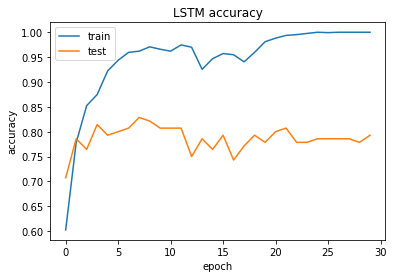

In [44]:
show_results(history_lstm,"LSTM")

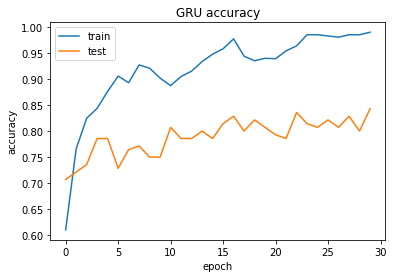

In [45]:
show_results(history_gru,"GRU")

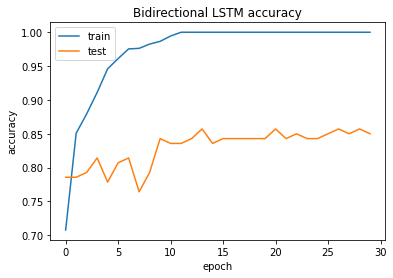

In [46]:
show_results(history_lstm_biedirectional,"Bidirectional LSTM")

### 2-Fine tuning bert model with custom layers

In [47]:
tokenizer = AutoTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment")
model = TFAutoModelForSequenceClassification.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment",output_hidden_states=True)

Some layers from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_113']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [48]:
# make only last 2 layers in bert are trainable
for layer in model.layers[:-2]:
  layer.trainable=False

for layer in model.layers[-2:]:
  layer.trainable=True


In [50]:
#tokenizing the data
tokenized_text = tokenizer(
        data_cleaned["cleaned"].tolist(),
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf",
    )

In [51]:
y_bert_fine_tune=to_categorical( data_cleaned["class"].tolist() )

In [52]:
x_input_ids=tokenized_text['input_ids'].numpy()
x_attention_mask=tokenized_text['attention_mask'].numpy()

In [53]:
x_input_ids,x_attention_mask, y_bert_fine_tune = shuffle(x_input_ids,x_attention_mask, y_bert_fine_tune, random_state=0)

In [54]:
x_input_ids_train, x_input_ids_test,x_attention_mask_train, x_attention_mask_test,y_bert_fine_tune_train , y_bert_fine_tune_test= train_test_split(x_input_ids, x_attention_mask,y_bert_fine_tune, test_size=0.1, random_state=42)

In [55]:
inpt1=tf.keras.layers.Input(shape=(None,),dtype=tf.int64)
inpt2=tf.keras.layers.Input(shape=(None,),dtype=tf.int64)
out=model([inpt1,inpt2])
d1=tf.keras.layers.Dense(7,activation="softmax")(out[1][-1][:,0,:])
custom_model=tf.keras.Model(inputs=[inpt1,inpt2],outputs=d1)

In [56]:
custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.categorical_crossentropy
                     ,metrics=["accuracy"])

In [57]:
history_bert=custom_model.fit(x=[ x_input_ids_train,x_attention_mask_train ],
                 y=y_bert_fine_tune_train,epochs=30,batch_size=8,
                 validation_data=( (x_input_ids_test,x_attention_mask_test), y_bert_fine_tune_test)
                 ,verbose=0)

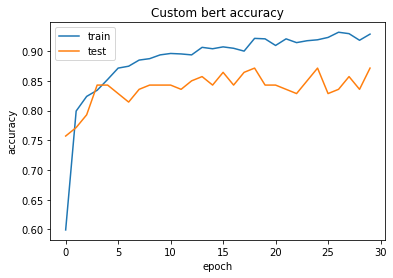

In [58]:
show_results(history_bert,"Custom bert")